# Part 0: Load in libraries

In [20]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Get and Analyze IDR clusters

## 1.1 - Load in IDR information

In [21]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

print(humandf)


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.2 - Load in IDR z-score data

In [22]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
fullzvec=np.load('../general_data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(fullzvec.shape)

print(np.max(fullzvec[0,:]))

90
(24508, 90)
6.44834990974164


## 1.3 - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length and min inter cluster distance gte 1.5

In [23]:
minidrlength=50
minidrlinkerlength=70
mininterclustdist=1.5

subidrsdf=humandf[humandf['IDR Length']>=minidrlength]
subidrsdf=subidrsdf[ (subidrsdf['IDR Length']>=minidrlinkerlength) | (subidrsdf['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
subidrsdf=subidrsdf[subidrsdf['Min Inter Clust Dist']>=mininterclustdist]
print(subidrsdf.isnull().any())
subidrsdf = subidrsdf.fillna('')
print(subidrsdf)

subaccs=subidrsdf['Uniprot'].tolist()
subaccswnums=subidrsdf['Uniprot w IDRnum'].tolist()
subgeneswnums=subidrsdf['Gene'].tolist()
subclusters=subidrsdf['Cluster Number'].tolist()
subseqlens=subidrsdf['IDR Length'].tolist()
substpos=subidrsdf['Start Pos'].tolist()
subenpos=subidrsdf['End Pos'].tolist()
subproteinlength=subidrsdf['Full Protein Length'].tolist()
submininterclustdist=subidrsdf['Min Inter Clust Dist'].tolist()
subtermini=subidrsdf['IDR Position'].tolist()
subseqs=subidrsdf['Sequence'].tolist()
sublocstring=subidrsdf['HPA Location'].tolist()


sublocationbyunistring=sublocstring


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24495       24495  Q6ZSZ5         Q6ZSZ5_1   ARHGEF1

## 1.3b - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length - used when don't care about cluster distance

In [24]:
subidrsdfNODIST=humandf[humandf['IDR Length']>=minidrlength]
subidrsdfNODIST=subidrsdfNODIST[ (subidrsdfNODIST['IDR Length']>=minidrlinkerlength) | (subidrsdfNODIST['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
print(subidrsdfNODIST.isnull().any())
subidrsdfNODIST = subidrsdfNODIST.fillna('')
print(subidrsdfNODIST)

subaccsNODIST=subidrsdfNODIST['Uniprot'].tolist()
subaccswnumsNODIST=subidrsdfNODIST['Uniprot w IDRnum'].tolist()
subgeneswnumsNODIST=subidrsdfNODIST['Gene'].tolist()
subclustersNODIST=subidrsdfNODIST['Cluster Number'].tolist()
subseqlensNODIST=subidrsdfNODIST['IDR Length'].tolist()
substposNODIST=subidrsdfNODIST['Start Pos'].tolist()
subenposNODIST=subidrsdfNODIST['End Pos'].tolist()
subproteinlengthNODIST=subidrsdfNODIST['Full Protein Length'].tolist()
submininterclustdistNODIST=subidrsdfNODIST['Min Inter Clust Dist'].tolist()
subterminiNODIST=subidrsdfNODIST['IDR Position'].tolist()
subseqsNODIST=subidrsdfNODIST['Sequence'].tolist()
sublocstringNODIST=subidrsdfNODIST['HPA Location'].tolist()


sublocationbyunistringNODIST=sublocstringNODIST

Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24498       24498  Q6ZSZ5         Q6ZSZ5_4   ARHGEF1

# Part 2: Examine enrichment of cancer driver genes by cluster

## Part 2.1 - Load in Cancer Driver Genes

* Data was extracted from here: https://www.intogen.org/search
* Paper: https://www.nature.com/articles/s41568-020-0290-x

In [25]:
dfcancer=pd.read_table('data/IntOGen_Driver_Genes/IntOGen-DriverGenes.tsv')

print(dfcancer)

cdrivergenes=dfcancer['Symbol'].tolist()
cdriversampleper=dfcancer['Samples (%)'].tolist()

mapdf=pd.read_table('../general_data/sapiens_uniprot_gene_name_all.tsv')
accsmap=mapdf['Uniprot'].tolist()
genesmap=mapdf['Gene'].tolist()

cdriveraccs=[]
for s in range(0,len(cdrivergenes)):
    #print(cdrivergenes[s])
    
    if cdrivergenes[s]=='H3-3A':
        cdrivergenes[s]='H3F3A'
    idx=genesmap.index(cdrivergenes[s])
    cdriveraccs.append(accsmap[idx])
    
print(len(cdriveraccs))

     Symbol Mutations Samples  Samples (%)  Cohorts
0      TP53    11,166   9,039        27.38      203
1      KRAS     2,822   2,632         7.97       84
2    PIK3CA     3,012   2,446         7.41      107
3      BRAF     1,786   1,416         4.29       52
4     KMT2D     3,064   1,312         3.97       86
..      ...       ...     ...          ...      ...
614  RECQL4       437       2         0.01        1
615    DDX6       155       2         0.01        1
616    KDSR       114       2         0.01        1
617     TFG       109       2         0.01        1
618    REST       304       2         0.01        1

[619 rows x 5 columns]
619


## 2.2 - Get enrichment of disease genes by cluster

In [26]:
numkclusts=30

pvalsbyclust=np.zeros((numkclusts))
pvalsbyclustlog=np.zeros((numkclusts))
disbyclustacc=[[] for _ in range(numkclusts)]
disbyclustgene=[[] for _ in range(numkclusts)]
disbyclustsampper=[[] for _ in range(numkclusts)]

for c in range(0,numkclusts):
    print('Cluster_'+str(c))
    midx = [i for i, x in enumerate(subclusters) if x == c]

    topaccs=[]
    for i in midx:
        topaccs.append(subaccswnums[i])

    subfeatureyes=0
    subfeatureno=0
    restfeatureyes=0
    restfeatureno=0
    for s in range(0,len(subaccs)):
        if subaccs[s] in cdriveraccs:
            if subaccswnums[s] in topaccs:
                subfeatureyes=subfeatureyes+1
                disbyclustacc[c].append(subaccswnums[s])
                disbyclustgene[c].append(subgeneswnums[s])
                tmpidx=cdriveraccs.index(subaccs[s])
                disbyclustsampper[c].append(cdriversampleper[tmpidx])
            else:
                subfeatureno=subfeatureno+1
        else:
            if subaccswnums[s] in topaccs:
                restfeatureyes=restfeatureyes+1
            else:
                restfeatureno=restfeatureno+1

    print(subfeatureyes+subfeatureno+restfeatureyes+restfeatureno)

    # defining the table
    if subfeatureyes+restfeatureyes>0:
        data = [[subfeatureyes, subfeatureno], [restfeatureyes, restfeatureno]]
        print(data)
        # One-sided greater used to test if greater occurrence in nucleolus
        res = fisher_exact(data, alternative='greater')
        print(res[1])
        pvalsbyclust[c]=res[1]
        pvalsbyclustlog[c]=-math.log10(res[1])

print(pvalsbyclust)
print(pvalsbyclustlog)


Cluster_0
8560
[[16, 637], [228, 7679]]
0.7728130263488877
Cluster_1
8560
[[31, 622], [282, 7625]]
0.07909320070898077
Cluster_2
8560
[[4, 649], [97, 7810]]
0.9553790174299356
Cluster_3
8560
[[33, 620], [366, 7541]]
0.33761051226914107
Cluster_4
8560
[[27, 626], [301, 7606]]
0.367527689860089
Cluster_5
8560
[[10, 643], [169, 7738]]
0.8854816674190782
Cluster_6
8560
[[41, 612], [421, 7486]]
0.17103547053645304
Cluster_7
8560
[[15, 638], [240, 7667]]
0.8854444865030302
Cluster_8
8560
[[12, 641], [102, 7805]]
0.15875942478911664
Cluster_9
8560
[[26, 627], [373, 7534]]
0.8294906779322772
Cluster_10
8560
[[35, 618], [148, 7759]]
2.8976942258675825e-07
Cluster_11
8560
[[27, 626], [124, 7783]]
2.397722699449257e-05
Cluster_12
8560
[[27, 626], [220, 7687]]
0.03620501718828203
Cluster_13
8560
[[24, 629], [283, 7624]]
0.48147166438748057
Cluster_14
8560
[[25, 628], [244, 7663]]
0.1751625854091049
Cluster_15
8560
[[13, 640], [163, 7744]]
0.5904652102518606
Cluster_16
8560
[[25, 628], [236, 7671]]

## 2.3 - Save p-values

In [23]:
#np.savetxt('data/Cancer_driver_enrichment_by_cluster_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt', pvalsbyclustlog)

## 2.4 - Plot enrichment of GIN clusters in cancer driver proteins

[5.28386620e-02 4.71584039e-01 3.17429267e-01 1.98243012e-02
 7.99260483e-01 3.56185477e-02 4.34709935e-01 6.78617284e-03
 4.62990377e-01 1.44123124e+00 5.28204258e-02 8.11884903e-02
 3.54301376e-01 7.56558653e-01 2.78793644e-01 1.54514066e-01
 1.89366923e-08 9.37934620e-02 6.53794744e+00 1.10186085e+00
 3.68282342e-01 3.92140431e-01 7.58235645e-03 1.11925566e-01
 1.09084528e-03 8.55897249e-01 4.62020105e+00 2.28805686e-01
 7.66913813e-01 8.62389979e-01]
[False False False False False False False False False  True False False
 False False False False False False  True False False False False False
 False False  True False False False]


([<matplotlib.axis.XTick at 0x145f71768a50>,
 [Text(0, 0, '7'),
  Text(1, 0, '3'),
  Text(2, 0, '13'),
  Text(3, 0, '2'),
  Text(4, 0, '8'),
  Text(5, 0, '19'),
  Text(6, 0, '4'),
  Text(7, 0, '24'),
  Text(8, 0, '18'),
  Text(9, 0, '12'),
  Text(10, 0, '5'),
  Text(11, 0, '9'),
  Text(12, 0, '23'),
  Text(13, 0, '14'),
  Text(14, 0, '25'),
  Text(15, 0, '26'),
  Text(16, 0, '29'),
  Text(17, 0, '17'),
  Text(18, 0, '10'),
  Text(19, 0, '1'),
  Text(20, 0, '21'),
  Text(21, 0, '27'),
  Text(22, 0, '22'),
  Text(23, 0, '0'),
  Text(24, 0, '20'),
  Text(25, 0, '16'),
  Text(26, 0, '11'),
  Text(27, 0, '15'),
  Text(28, 0, '6'),
  Text(29, 0, '28')])

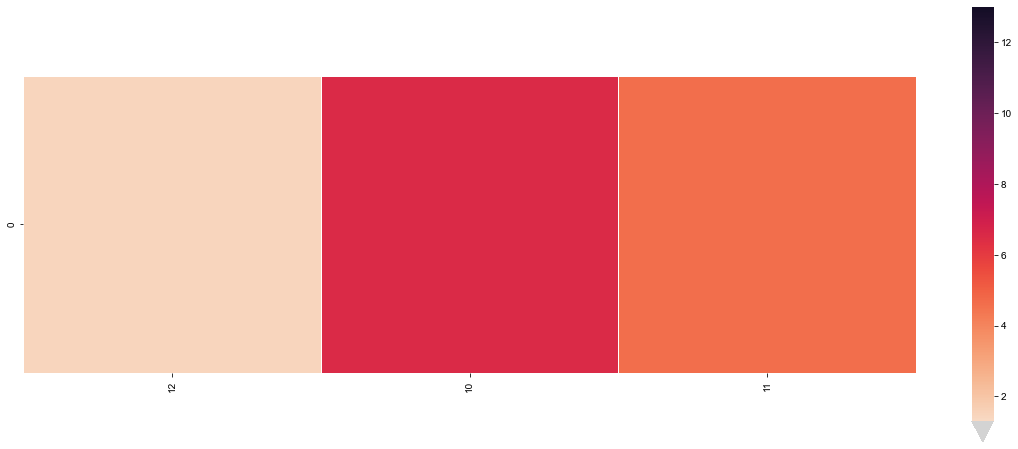

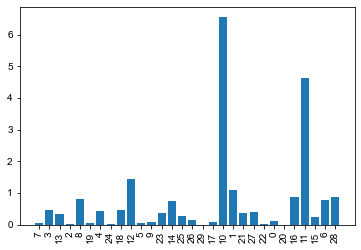

In [27]:
import matplotlib as mpl
import seaborn as sbn
import math

myclustorder=[7, 3, 13, 2, 8, 19, 4, 24, 18, 12, 5, 9, 23, 14, 25, 26, 29, 17, 10, 1, 21, 27, 22, 0, 20, 16, 11, 15, 6, 28]

tmp=np.loadtxt('data/Cancer_driver_enrichment_by_cluster_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt')


pvalsbylocationlog2=tmp
pvalsbylocationlog2[:] = pvalsbylocationlog2[myclustorder]
print(pvalsbylocationlog2)

mymask=(pvalsbylocationlog2 > -math.log10(0.05));
print((pvalsbylocationlog2 > -math.log10(0.05)))
#print(pvalsbylocation[:,mymask])

mysubfeats=[]
for i in range(0,len(mymask)):
    if mymask[i] == True:
        mysubfeats.append(myclustorder[i])


c = sbn.color_palette('rocket_r', 20)
green = mpl.colors.LinearSegmentedColormap.from_list('alex_lv', c)
green.set_under(alpha=0)
green.set_under('lightgrey')

## If want to look at all 90 features
fig, ax = plt.subplots(figsize = (20, 8)) 
sbn.heatmap([pvalsbylocationlog2[mymask]],cmap=green,vmin=-math.log10(0.05), vmax=13, cbar_kws={'extend': 'min'}, square=True, linewidth=.5)
#plt.yticks(np.arange(0.5, len(uniqueloc), 1), uniqueloc,rotation=0) 
plt.xticks(np.arange(0.5, len(mysubfeats), 1), mysubfeats,rotation=90) 

plt.figure()
plt.bar(np.arange(0,len(pvalsbylocationlog2),1),pvalsbylocationlog2)
plt.xticks(np.arange(0,len(myclustorder),1),myclustorder,rotation=90)

## 2.5 - Plot enrichment for all GIN clusters sorted

[16 24  7 22  3  5 10  0 11 17 23 15 27 14  2 12 20 21  6  8  1 13 28  4
 25 29 19  9 26 18]


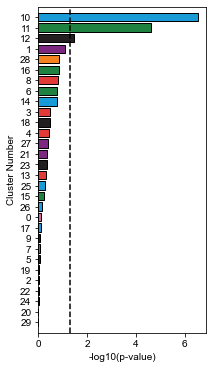

In [28]:
colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']


sortedidx=np.argsort(pvalsbylocationlog2)
print(sortedidx)

sortedpvalsbylocationlog2=[]
sortedmyclustorder=[]
sortedcolor=[]
for i in range(0,len(sortedidx)):
    sortedpvalsbylocationlog2.append(pvalsbylocationlog2[sortedidx[i]])
    sortedmyclustorder.append(myclustorder[sortedidx[i]])
    sortedcolor.append(colorhex[myclustorder[sortedidx[i]]])

plt.figure(figsize=(3,6))
plt.barh(np.arange(0,len(sortedpvalsbylocationlog2),1),sortedpvalsbylocationlog2,color=sortedcolor,edgecolor='black')
plt.yticks(np.arange(0,len(sortedmyclustorder),1),sortedmyclustorder)
plt.plot([-math.log10(0.05),-math.log10(0.05)],[-1,30],'--k')
plt.ylim([-1, 30])
plt.ylabel('Cluster Number')
plt.xlabel('-log10(p-value)')

#plt.savefig('Figures/2024_02/cancer_drivers/Enrichment_of_IDRs_by_cluster_in_cancer_drivers.pdf', transparent=False, bbox_inches = "tight")

dftmp=pd.DataFrame()
dftmp['Cluster']=sortedmyclustorder
dftmp['-log10(p-value)']=sortedpvalsbylocationlog2

#print(dftmp)
#with pd.ExcelWriter('../Supplementary_Tables/Table_S7.xlsx', engine='openpyxl') as writer:
#    dftmp.to_excel(writer,sheet_name='Fig_S7A')

## 2.6 - Create dataframe where IDR number is removed from gene name

In [29]:
tmpacclist=[]
tmpgenelist=[]
tmpclustlist=[]
tmpdislist=[]
tmpsampperlist=[]
tmpgenenonumlist=[]
for c in range(0,numkclusts):
    for i in range(0,len(disbyclustacc[c])):
        tmpacclist.append(disbyclustacc[c][i])
        tmpgenelist.append(disbyclustgene[c][i])
        tmpclustlist.append(c)
        tmpsampperlist.append(disbyclustsampper[c][i])
        tmp=disbyclustgene[c][i].split(' ')
        tmpgenenonumlist.append(tmp[0])
            
                
    
dfdisbyclust=pd.DataFrame()
dfdisbyclust['Gene no Num']=tmpgenenonumlist
dfdisbyclust['Gene']=tmpgenelist
dfdisbyclust['Uniprot']=tmpacclist
dfdisbyclust['Cluster']=tmpclustlist
dfdisbyclust['Samples %']=tmpsampperlist

dfdisbyclust=dfdisbyclust.sort_values(by='Samples %',ascending=False)

print(dfdisbyclust)
print(dfdisbyclust[dfdisbyclust['Cluster']==11])

#dfdisbyclust.to_excel('KEGG_disease_w_clusters_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'.xlsx')


    Gene no Num         Gene    Uniprot  Cluster  Samples %
250       KMT2D   KMT2D IDR7   O14686_7       11       3.97
305       KMT2D  KMT2D IDR13  O14686_13       13       3.97
587       KMT2D   KMT2D IDR2   O14686_2       27       3.97
519       KMT2D   KMT2D IDR4   O14686_4       24       3.97
518       KMT2D   KMT2D IDR1   O14686_1       24       3.97
..          ...          ...        ...      ...        ...
299       NCAPH   NCAPH IDR1   Q15003_1       12       0.01
544       SALL4   SALL4 IDR5   Q9UJQ4_5       24       0.01
542        REST    REST IDR4   Q13127_4       24       0.01
312       EPS15   EPS15 IDR3   P42566_3       13       0.01
205        PCM1   PCM1 IDR12  Q15154_12        9       0.01

[653 rows x 5 columns]
    Gene no Num          Gene    Uniprot  Cluster  Samples %
250       KMT2D    KMT2D IDR7   O14686_7       11       3.97
251       KMT2D    KMT2D IDR9   O14686_9       11       3.97
252       KMT2D   KMT2D IDR10  O14686_10       11       3.97
254      ARI

## 2.7 - Filter dataframe for just proteins with the 3 enriched clusters

In [30]:
dfdisbyclustuni=pd.DataFrame()
dfdisbyclustuni['Gene no Num']=tmpgenenonumlist
dfdisbyclustuni['Cluster']=tmpclustlist
dfdisbyclustuni['Samples %']=tmpsampperlist

dfdisbyclustuni=dfdisbyclustuni.sort_values(by='Samples %',ascending=False)

dfdisbyclustuni=dfdisbyclustuni.drop_duplicates()
print(dfdisbyclustuni)

print(dfdisbyclustuni[dfdisbyclustuni['Cluster'].isin([10,11,12])].head(50))

dfdisbyclustuni101112=dfdisbyclustuni[dfdisbyclustuni['Cluster'].isin([10,11,12])]

genelist101112=dfdisbyclustuni101112['Gene no Num'].tolist()
sampper101112=dfdisbyclustuni101112['Samples %'].tolist()
clustlist101112=dfdisbyclustuni101112['Cluster'].tolist()

    Gene no Num  Cluster  Samples %
250       KMT2D       11       3.97
305       KMT2D       13       3.97
587       KMT2D       27       3.97
519       KMT2D       24       3.97
16        KMT2D        1       3.97
..          ...      ...        ...
294        BRD4       12       0.01
299       NCAPH       12       0.01
544       SALL4       24       0.01
542        REST       24       0.01
312       EPS15       13       0.01

[569 rows x 3 columns]
    Gene no Num  Cluster  Samples %
250       KMT2D       11       3.97
279       KMT2D       12       3.97
254      ARID1A       11       3.54
289       KMT2C       12       3.32
263       KMT2C       11       3.32
235       KMT2C       10       3.32
234      NOTCH1       10       1.81
220      CREBBP       10       1.28
253      CREBBP       11       1.28
267       ARID2       11       1.25
245       KDM6A       10       1.20
249     SMARCA4       10       1.15
288       SETD2       12       1.04
296        ATRX       12       1.00
226 

## 2.8 - Plot frequency of mutations and whether the protein houses a cluster 10, 11, or 12 IDR

       Gene  Sample %  Cluster 10  Cluster 11  Cluster 12
0     KMT2D      3.97           0           1           1
1    ARID1A      3.54           0           1           0
2     KMT2C      3.32           1           1           1
3    NOTCH1      1.81           1           0           0
4    CREBBP      1.28           1           1           0
5     ARID2      1.25           0           1           0
6     KDM6A      1.20           1           0           0
7   SMARCA4      1.15           1           0           0
8     SETD2      1.04           0           0           1
9      ATRX      1.00           0           0           1
10    EP300      0.81           1           1           0
11    ZFHX3      0.73           0           1           0
12    STAG2      0.46           0           0           1
13   ARID1B      0.39           1           0           0
14    KMT2A      0.34           1           0           1
15     CHD4      0.31           0           0           1
16     SOX9   

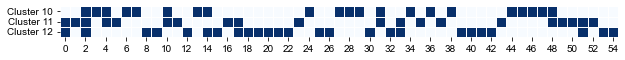

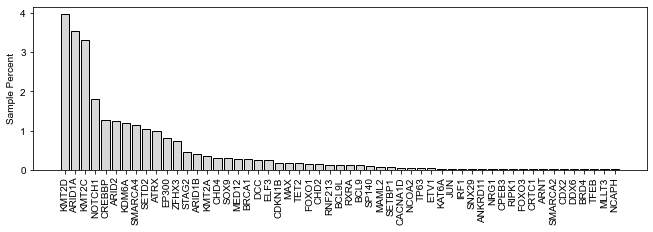

In [31]:
unigenelist=[]
in10=[]
in11=[]
in12=[]
unisampper=[]
for i in range(0,len(genelist101112)):
    if genelist101112[i] not in unigenelist:
        unigenelist.append(genelist101112[i])
        unisampper.append(sampper101112[i])
        
        pos=[j for j, x in enumerate(genelist101112) if x==genelist101112[i]]
        tmpclusts=[]
        for p in pos:
            tmpclusts.append(clustlist101112[p])
            
        if 10 in tmpclusts:
            in10.append(1)
        else:
            in10.append(0)
            
        if 11 in tmpclusts:
            in11.append(1)
        else:
            in11.append(0)
            
        if 12 in tmpclusts:
            in12.append(1)
        else:
            in12.append(0)
            
cdriver101112=pd.DataFrame()
cdriver101112['Gene']=unigenelist
cdriver101112['Sample %']=unisampper
cdriver101112['Cluster 10']=in10
cdriver101112['Cluster 11']=in11
cdriver101112['Cluster 12']=in12

print(cdriver101112)

plt.figure(figsize=(10,3))
sbn.heatmap(cdriver101112[['Cluster 10','Cluster 11','Cluster 12']].transpose(),square=True,linewidth=0.5,cbar=False,cmap='Blues')
#plt.savefig('Figures/2024_02/cancer_drivers/Cancer_drivers_w_cluster_10_11_12_IDRs.pdf', transparent=False, bbox_inches = "tight")

plt.figure(figsize=(11,3))
plt.bar(np.arange(0,len(unisampper),1),unisampper,color='#d7d7d7',edgecolor='black')
plt.xticks(np.arange(0,len(unigenelist),1),unigenelist,rotation=90)
plt.ylabel('Sample Percent')
#plt.savefig('Figures/2024_02/cancer_drivers/Cancer_drivers_w_cluster_10_11_12_IDRs_sample_percent_bar.pdf', transparent=False, bbox_inches = "tight")

#with pd.ExcelWriter('../Supplementary_Tables/Table_S7.xlsx', engine='openpyxl',mode='a') as writer:
#    cdriver101112.to_excel(writer,sheet_name='Fig_S7B')